<a href="https://colab.research.google.com/github/marcotao23/Individual-Projects/blob/master/Pair_Trading_S_Score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pairs Trading

In [ ]:
#To install the dev version of statsmodels:
!pip install git+https://github.com/statsmodels/statsmodels

#To install yfiance:
!pip install yfinance

#To install the pyfinance:
!pip3 install pyfinance

  Cloning https://github.com/statsmodels/statsmodels to /tmp/pip-req-build-kat4p3d5
  Running command git clone -q https://github.com/statsmodels/statsmodels /tmp/pip-req-build-kat4p3d5
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for statsmodels: filename=statsmodels-0.13.0.dev0+127.g36b7f5ddf-cp36-cp36m-linux_x86_64.whl size=17738571 sha256=69d0836347f7c72f298e857f2e49ac12b6d6d71372325d5fe27a7a0e235554be
  Stored in directory: /tmp/pip-ephem-wheel-cache-1oh76yat/wheels/7d/ad/45/ac1a03bd759c2fa74c486e2b1950d94b55f511b4c2b0418bd5
Successfully built statsmodels


In [1]:
## Import packages
import pandas as pd
import numpy as np
#from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import yfinance as yf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ImportError: ignored

In [ ]:
class Pair:
  # A pair consists of two stocks  
  # All dates should in string format "YYYY-MM-DD"

  def __init__(self, stock_ticker, etf_ticker, starttime="2020-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), period='1d', interval=60, counter=0):
    #constuctor
    self.stock = stock_ticker
    self.etf = etf_ticker
    self.start = starttime
    self.end = endtime
    self.period = period
    self.interval = interval
    self.counter = counter
  
  def getData(self, startdate=None, enddate=None):
    #obtain adj close price for input tickers from yahoo finance
    ''' return a dataframe of tickers period return '''
    if startdate==None:
      startdate=self.start
    if enddate==None:
      enddate=self.end
    if startdate==self.start and enddate==self.end:
      print("getting all data from start to end")
    stockprice = yf.Ticker(self.stock).history(period=self.period, start=startdate, end=enddate)["Close"].rename(self.stock).pct_change().dropna()
    etfprice = yf.Ticker(self.etf).history(period=self.period, start=startdate, end=enddate)["Close"].rename(self.etf).pct_change().dropna()
    data = pd.concat([stockprice, etfprice], axis=1, sort=False)
    #print("getting data...")
    return data

  def regressor(self, date):
    #linear regression the stock return on etf return (1)
    ''' return array of resid of the regression '''
    returns = self.getData(startdate = (datetime.strptime(date, '%Y-%m-%d') - timedelta(self.interval)).strftime('%Y-%m-%d'), enddate = date)
    endog = returns.iloc[:, 0].values  #y
    exog = sm.add_constant(returns.iloc[:, 1].values) #add intercept to x
    mod = sm.OLS(endog=endog, exog=exog)
    model = mod.fit()
    #print("regression model fitted...")
    return model.resid

  def X(self, date):
    #create auxiliary process X (2) 
    ''' return array of process X '''
    resid = self.regressor(date = date)
    X = np.zeros(len(resid))
    X[0] = resid[0]
    for i in range(1,len(resid)):
      X[i] = X[i-1] + resid[i]
    return X

  def AutoRegressor(self, date):
    #AR(1) on the process X (3)
    ''' return tupel(a,b,k,sigma_eq) '''
    armod = AutoReg(self.X(date = date), lags=1, old_names = False)
    armodel = armod.fit()
    a = armodel.params[0]
    b = armodel.params[1]
    k = -np.log(b)*252
    variance = np.var(armodel.resid)
    sigma_eq = np.sqrt(variance / (1 - b**2))
    self.counter = self.counter + 1
    print("Calculating ... day %i" %(self.counter), end="\r")
    return (a,b,k,sigma_eq)

  def detail(self, date=datetime.today().strftime('%Y-%m-%d')):
    #Print details of OU parameters (4)(5)
    ''' return none '''
    result = self.AutoRegressor(date = date)
    a = result[0]
    b = result[1]
    k = result[2]
    sigmaeq = result[3]
    sigma = result[3] * np.sqrt(2*k)
    s = -(result[0] / (1 - result[1])) / result[3]
    print("a=%f, b=%f, k=%f, sigma=%f, sigma equilibrium=%f, s=%f" %(a,b,k,sigma,sigmaeq,s))

  def calcScore(self, date=datetime.today().strftime('%Y-%m-%d')):
    #Gives S-Score of the date, calling without input gives today's S-score (6)
    ''' return float S-score '''
    self.counter = 0
    result = self.AutoRegressor(date = date)
    m = result[0] / (1 - result[1])
    s = -m / result[3]
    return s
  
  def rolling(self):
    #calcualte S scores from start date to end date
    ''' return list of S scores '''
    date = self.start
    Sscore = []
    while(datetime.strptime(date, '%Y-%m-%d').strftime('%Y-%m-%d') != self.end):
      Sscore.append(self.calcScore(date = date))
      date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(1)).strftime('%Y-%m-%d')
    Sscore.append(self.calcScore(date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(1)).strftime('%Y-%m-%d')))
    return Sscore
  
  def plot(self):
    ''' plot S scores calculated in the rolling method''' 
    scores = self.rolling()
    Scores = pd.DataFrame(scores, columns=["S-Score"], index=pd.date_range(start=self.start, end=self.end, freq='D'))
    plt.figure(figsize=(20,10))
    Scores.plot()
    return


In the case when period = 1d and interval = 60:

(1) $R_{n}^{S}=\beta_{0}+\beta R_{n}^{ETF}+\epsilon_{n}, \quad n=1,2, \ldots, 60$

(2) $X_{k}=\sum_{j=1}^{k} \epsilon_{j} \quad k=1,2, \ldots, 60  ,\quad X_{60}=0$

(3) $X_{n+1}=a+b X_{n}+\zeta_{n+1}, \quad n=1, \ldots, 59$

(4) $\begin{aligned} a &=m\left(1-e^{-\kappa \Delta t}\right) \\ b &=e^{-\kappa \Delta t} \\ \text { Variance }(\zeta) &=\sigma^{2} \frac{1-e^{-2 \kappa \Delta t}}{2 \kappa} \end{aligned}$ 

(5) $\begin{aligned} \kappa &=-\log (b) * 252 \\ m &=\frac{a}{1-b} \\ \sigma &=\sqrt{\frac{\text { Variance }(\zeta) \cdot 2 \kappa}{1-b^{2}}} \\ \sigma_{e q} &=\sqrt{\frac{\text { Variance }(\zeta)}{1-b^{2}}} \end{aligned}$

(6) $s=\frac{X(t)-m}{v_{e q}}, \quad X_{t}=0$

$s=\frac{-m}{\sigma_{e q}}=\frac{-a \cdot \sqrt{1-b^{2}}}{(1-b) \cdot \sqrt{\operatorname{Variance}(\zeta)}}$





In [ ]:
p1 = Pair("JPM", "XLF", starttime="2006-01-01", endtime="2007-12-04")

In [ ]:
p1.detail("2006-02-03")

a=-0.000336, b=0.912491, k=23.077541, sigma=0.088839, sigma equilibrium=0.013077, s=0.293397


<Figure size 1440x720 with 0 Axes>

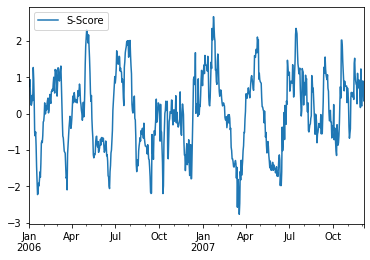

In [ ]:
p1.plot()